# Pipeline de processamento dos dados FAMES
Lista de tarefas:
1. Definir canais a serem utilizados
1. Deadtime correction. Máximo deve ser de até uns 10 MHz, acima disso é dificil de corrigir
1. Background subtraction
1. Médias
1. Calculo de extinction rate aerosol com Klett e Raman combinado
1. Calculo backscattering para aerosol
1. Calculo mixing ratio metano/co2 para eficiencia de combustão
1. Calculo mixing ratio metano/n2 para concentração de metano
1. Calcula mixing ration co2/n2 para concentração de co2
1. TODO Precisa verificar se não tem crosstalk entre o 355 e 353
1. TODO Verificar influencia da fluorescencia


In [114]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from importlib import reload

from lifa.licel import LicelLidarMeasurement
from lifa.processing import fit_checks; reload(fit_checks)
from lifa.processing import pre_processing; reload(pre_processing)
from lifa.processing import helper_functions
from lifa.processing import raman_mixing_ratio

## Abre arquivos de dados

In [116]:
files = [ r"d:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.354537"]

files = [ r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.382991',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.354537',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.362648',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.370762',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.374877' ]


files = [ r'd:\FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250829 CEPEMA FAMES FULL\a2590216.531835']

files = [ r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.022272',
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.552826', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.560971', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.565115', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.573260', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.581404', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.585549', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.593694', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.001838', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.005984', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.014128',
         ]

#files = [r'd:\FAMES\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm\a24C0506.014128']

dead_time = 1/240   #(1/200 MHz)

measurements = LicelLidarMeasurement(files)

upper_signal = {}
upper_signal['n2_raman_353'] = measurements.channels['00353.o_ph']
upper_signal['rayleigh_355'] = measurements.channels['00355.o_ph']
upper_signal['co2_raman_371'] = measurements.channels['00371.o_ph']
upper_signal['ch4_raman_395_s'] = measurements.channels['00395.s_ph']
upper_signal['ch4_raman_395_p'] = measurements.channels['00395.p_ph']
upper_signal['fluo_460'] = measurements.channels['00460.o_ph']
upper_signal['n2_raman_530'] = measurements.channels['00530.o_ph']
upper_signal['rayleigh_532'] = measurements.channels['00532.o_ph']

lower_signal = {}
lower_signal['n2_raman_353'] = measurements.channels['00353.o_an']
lower_signal['rayleigh_355'] = measurements.channels['00355.o_an']
lower_signal['co2_raman_371'] = measurements.channels['00371.o_an']
lower_signal['ch4_raman_395_s'] = measurements.channels['00395.s_an']
lower_signal['ch4_raman_395_p'] = measurements.channels['00395.p_an']
lower_signal['fluo_460'] = measurements.channels['00460.o_an']
lower_signal['n2_raman_530'] = measurements.channels['00530.o_an']
lower_signal['rayleigh_532'] = measurements.channels['00532.o_an']


z = measurements.channels['00355.o_an'].z

### Pre processamento

In [117]:

# pre process
idx_min = 12000
idx_max = 15000

for key,val in lower_signal.items():
    if lower_signal[key].is_photon_counting:
        lower_signal[key] = pre_processing.correct_count_rate_dead_time_nonparalyzable(lower_signal[key].average_profile(), dead_time)
        lower_signal[key], background_mean, background_std = pre_processing.subtract_background(lower_signal[key], idx_min, idx_max)
        signal_type = "photon counting rate [MHz]" 
    else:
        lower_signal[key], background_mean, background_std = pre_processing.subtract_background(lower_signal[key].average_profile(), idx_min, idx_max)
        signal_type = "analog [mV]"
    print('Signal: {}, type: {}, background mean: {}, std {}'.format(key, signal_type, background_mean, background_std))

for key,val in upper_signal.items():
    if upper_signal[key].is_photon_counting:
        upper_signal[key] = pre_processing.correct_count_rate_dead_time_nonparalyzable(upper_signal[key].average_profile(), dead_time)
        upper_signal[key], background_mean, background_std = pre_processing.subtract_background(upper_signal[key], idx_min, idx_max)
        signal_type = "photon counting rate [MHz]" 
    else:
        upper_signal[key], background_mean, background_std = pre_processing.subtract_background(upper_signal[key].average_profile(), idx_min, idx_max)
        signal_type = "analog [mV]"
    print('Signal: {}, type: {}, background mean: {}, std {}'.format(key, signal_type, background_mean, background_std))

Signal: n2_raman_353, type: analog [mV], background mean: 5.498618350390493, std 6.1907219961815e-05
Signal: rayleigh_355, type: analog [mV], background mean: 5.202683690838735, std 0.0001197471348881544
Signal: co2_raman_371, type: analog [mV], background mean: 5.481804679342349, std 6.011794362430175e-05
Signal: ch4_raman_395_s, type: analog [mV], background mean: 5.533906360904926, std 6.104121808023165e-05
Signal: ch4_raman_395_p, type: analog [mV], background mean: 5.550280098851292, std 6.33022896441983e-05
Signal: fluo_460, type: analog [mV], background mean: 5.545775615121851, std 0.00014206044142957774
Signal: n2_raman_530, type: analog [mV], background mean: 5.588384583659126, std 6.617057661990532e-05
Signal: rayleigh_532, type: analog [mV], background mean: 5.350312500085768, std 0.00012159123942122884
Signal: n2_raman_353, type: photon counting rate [MHz], background mean: 4.618750483376686e-05, std 0.00020247292227990304
Signal: rayleigh_355, type: photon counting rate [M

In [118]:
# Escolhe sinais que vamos utilizar e faz bin shift para alinhar
signal = {}
signal['n2_raman_353'] = lower_signal['n2_raman_353']
signal['rayleigh_355'] = lower_signal['rayleigh_355']
signal['co2_raman_371'] = pre_processing.correct_trigger_delay_bins(upper_signal['co2_raman_371'], 4)
signal['ch4_raman_395_s'] = pre_processing.correct_trigger_delay_bins(upper_signal['ch4_raman_395_s'], 4)
signal['ch4_raman_395_p'] = pre_processing.correct_trigger_delay_bins(upper_signal['ch4_raman_395_p'], 4)
signal['fluo_460'] = pre_processing.correct_trigger_delay_bins(lower_signal['fluo_460'], 1)
signal['n2_raman_530'] = lower_signal['n2_raman_530']
signal['rayleigh_532'] = lower_signal['rayleigh_532']

# Posição do flare em metros
flare_pos = z[helper_functions.find_nearest(400, z)]

### Visualização dos dados
Visualizção dos dados em escala linear em sem correção de range. Isso permite avaliar o seguinte:
- Sincronia entre os canais, posição do pico
- Sinais de contagem de fótons devem ser no máximo até 10 MHz, para evitar deformação por dead time

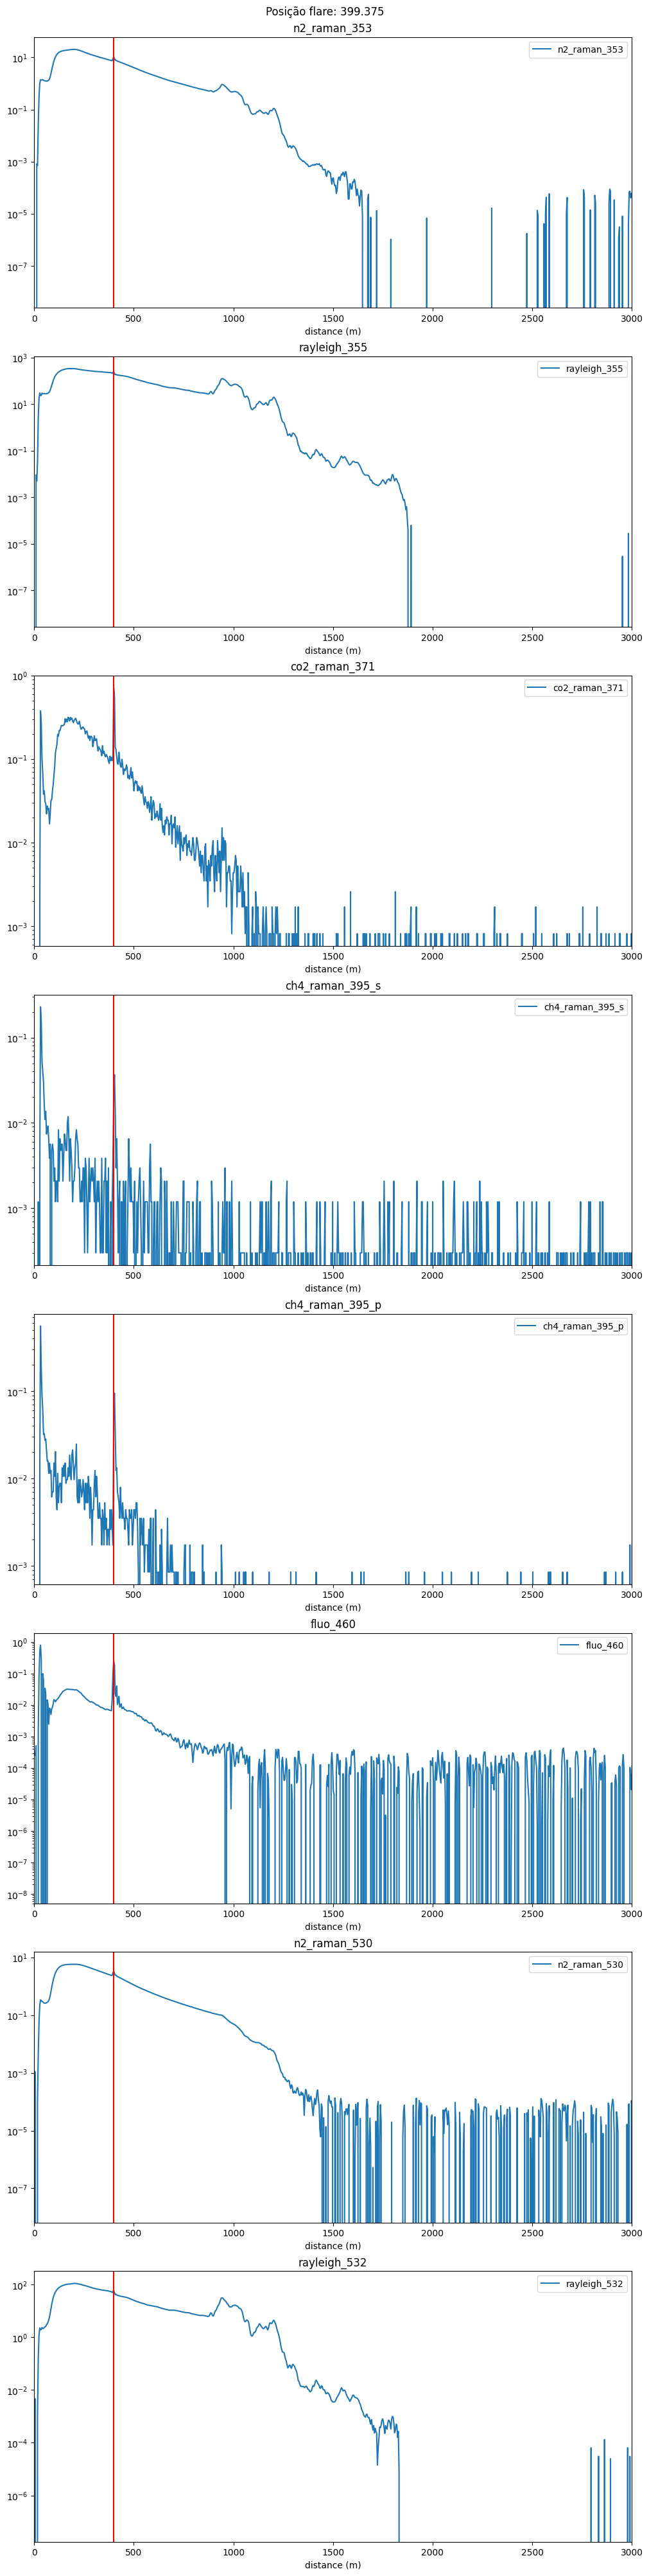

In [119]:
# apresenta todos sinais
#number_traces = len(licel_channels_names)
fig, ax = plt.subplots(nrows=len(upper_signal), figsize=(10,40), layout='constrained')
#plt.title('Photon-counting signal')
#fig.suptitle('Signals')

plt.suptitle('Posição flare: {}'.format(flare_pos))
for i,(key, data) in enumerate(signal.items()):
    ax[i].plot(z, data, label=key)
    ax[i].axvline(flare_pos, 0, 1, color='r')
    
    #plt.plot(z, non_paralyzable_corrected, 'g', label='Non paralyzable')

    #ax[i].plot(trace[0], trace[1], label=name, marker=',')
    ax[i].set_title(key)
    #ax[i].grid(True, 'both')
    #ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    #ax[i].set_ylabel('signal (mV)')
    ax[i].legend(loc='upper right')
    ax[i].set_yscale('log')
    ax[i].set_xlim(0,3000)

### Vizualização dados range corrected
Aqui é possível avaliar a qualidade dos dados e até onde eles são válidos.
Os dados são validos somente até o ponto em que a curva cai e começa subir novamente. Deste ponto em diante é somente ruído da detecção que está sendo "amplificado" pela correção de distância.

In [120]:
# aplica range correction
signal_rc = {}
for key,val in signal.items():
    signal_rc[key] = pre_processing.apply_range_correction(val, z)

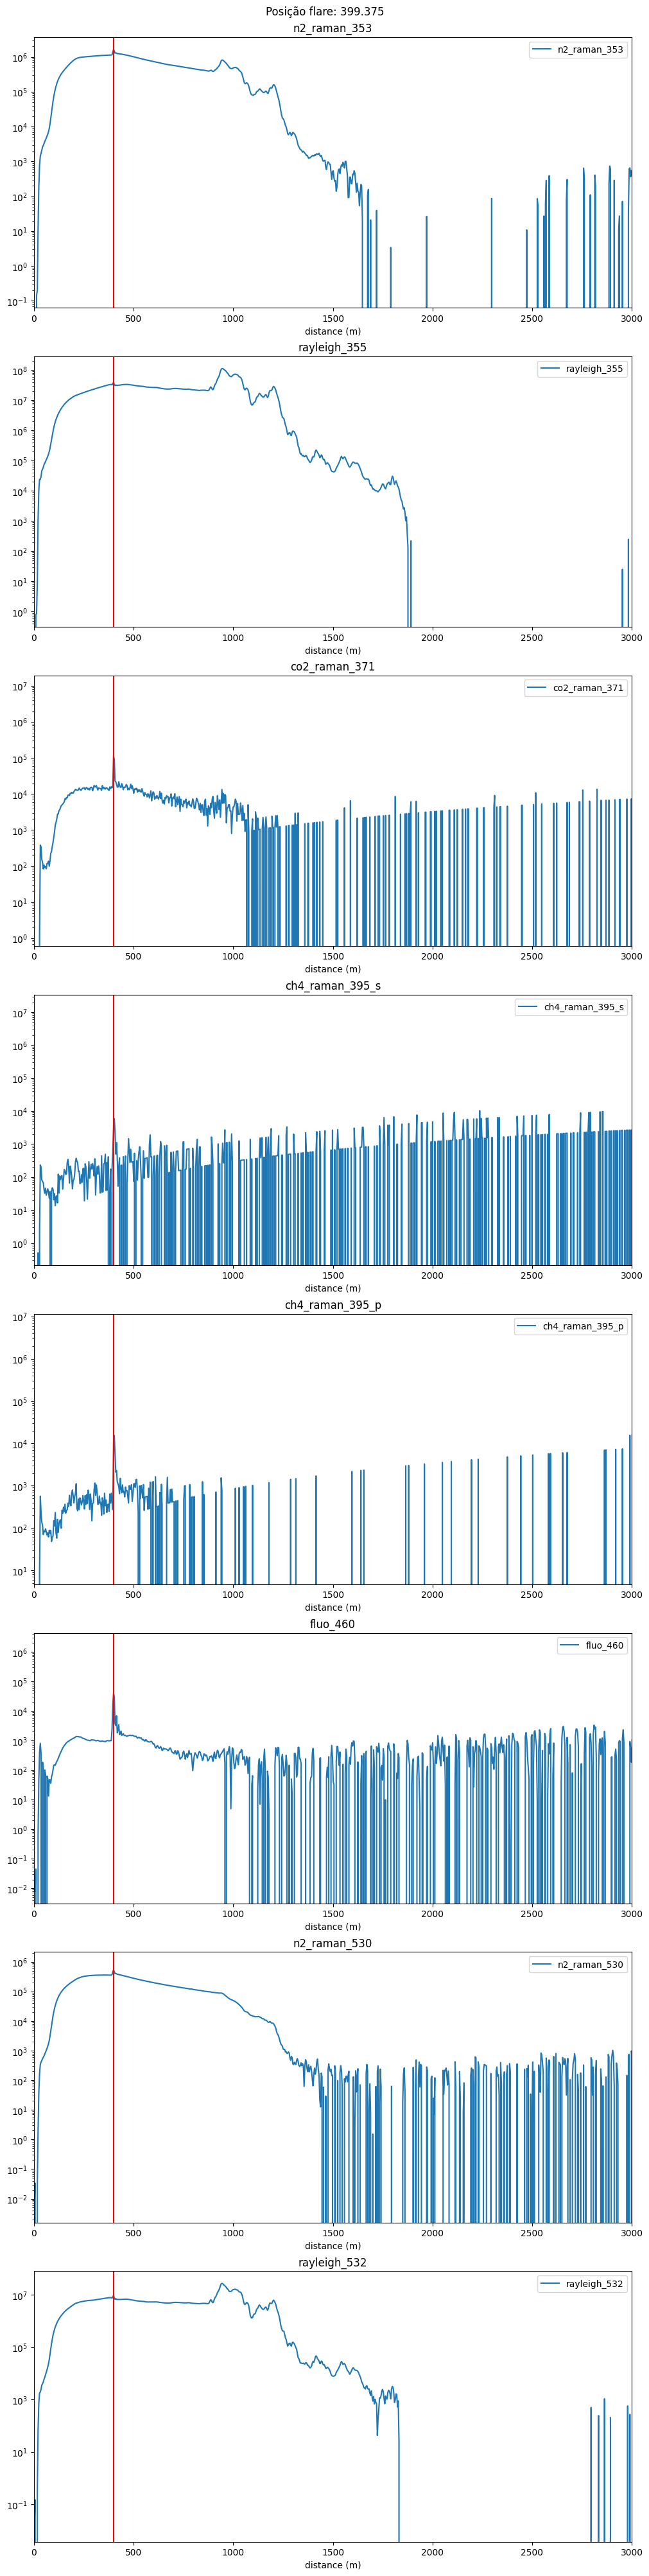

In [121]:
# apresenta todos sinais
#number_traces = len(licel_channels_names)
fig, ax = plt.subplots(nrows=len(upper_signal), figsize=(10,40), layout='constrained')
#plt.title('Photon-counting signal')
#fig.suptitle('Signals')

plt.suptitle('Posição flare: {}'.format(flare_pos))
for i,(key, data) in enumerate(signal_rc.items()):
    ax[i].plot(z, data, label=key)
    ax[i].axvline(flare_pos, 0, 1, color='r')
    
    #plt.plot(z, non_paralyzable_corrected, 'g', label='Non paralyzable')

    #ax[i].plot(trace[0], trace[1], label=name, marker=',')
    ax[i].set_title(key)
    #ax[i].grid(True, 'both')
    #ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    #ax[i].set_ylabel('signal (mV)')
    ax[i].legend(loc='upper right')
    ax[i].set_yscale('log')
    ax[i].set_xlim(0,3000)


## Mixing ratio

O sinal lidar é muito ruim. O ângulo é muito baixo e não é possível pegar atmosfera limpa onde identificamos somente espalhamento molecular. A distância máxima com dados é de aproximadamente 1700 metros. Isso num angulo aproximado de 12 graus, é uma diferenca de altura de XXXX...Estimar o esplhamento molecular após isso...

Por enquanto não vamos calcular o exticntion ratio do aerosol, somente o teórico molecular. Não sei como estimar o extinction ration para aer (precisa??)

In [129]:
elevation_angle = 12
elevation = 0
bin_min = helper_functions.find_nearest(z, 300)
bin_max = helper_functions.find_nearest(z, 600)
height = z * math.sin(math.radians(elevation_angle)) + elevation 

# Modelo Padrão Atmosfera
pressure, temperature, density = helper_functions.standard_atmosphere(height)

alpha_aer = np.zeros_like(height)

### CO2

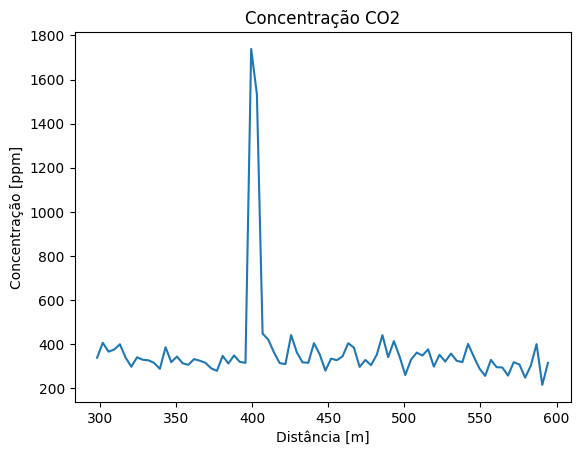

In [130]:
# Mixing ration CO2 e N2
co2_calib = 25000   # Concentração na atmosfera é aproximadamente 400 ppm
co2_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['co2_raman_371'], 
                                      signal_rc['n2_raman_353'], 
                                      3.75, 
                                      alpha_aer, 
                                      co2_calib, 
                                      371, 
                                      353, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], co2_mixing_ratio[bin_min:bin_max])
plt.title('Concentração CO2')
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [ppm]')
plt.show()

### CH4

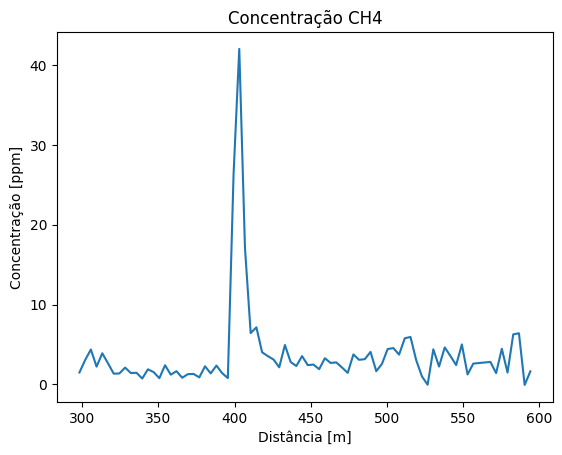

In [124]:
# Mixing ration CH4 e N2
ch4_calib = 4000   # Concentração na atmosfera é aproximadamente 2 ppm
ch4_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['ch4_raman_395_p'], 
                                      signal_rc['n2_raman_353'], 
                                      3.75, 
                                      alpha_aer, 
                                      ch4_calib, 
                                      395, 
                                      353, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], ch4_mixing_ratio[bin_min:bin_max])

plt.title('Concentração CH4')
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [ppm]')
plt.show()

### CE Mixing Ratio

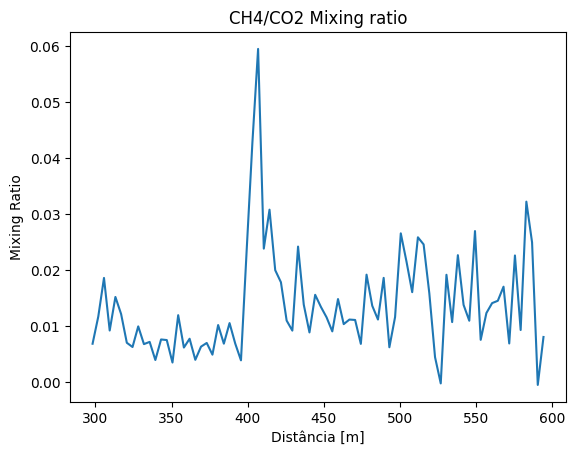

In [125]:
# Mixing ration CH4 e CO2
ce_calib = 0.25  # CE mixing ratio é 2/200 = 0,01
ce_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['ch4_raman_395_p'], 
                                      signal_rc['co2_raman_371'], 
                                      3.75, 
                                      alpha_aer, 
                                      ce_calib, 
                                      395, 
                                      371, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], ce_mixing_ratio[bin_min:bin_max])
plt.title('CH4/CO2 Mixing ratio')
plt.xlabel('Distância [m]')
plt.ylabel('Mixing Ratio')
plt.show()

### CE

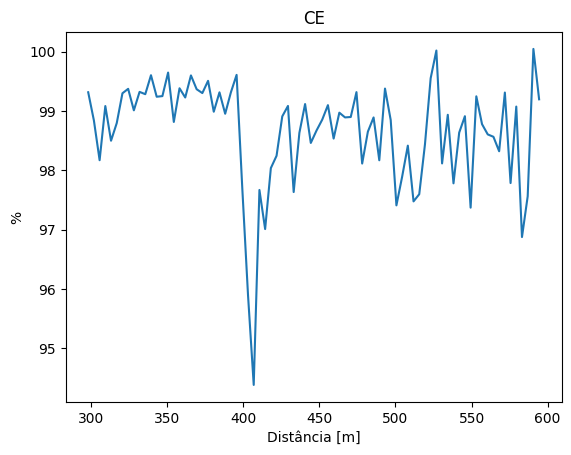

In [126]:
# CE para atmosfera é algo como 99. Não sei como converter isso para 100%...preciso pensar um pouco
ce = 1/(1 + ce_mixing_ratio) * 100
plt.plot(z[bin_min:bin_max], ce[bin_min:bin_max])
plt.title('CE')
plt.xlabel('Distância [m]')
plt.ylabel('%')
plt.show()